In [1]:
#importing necessary libraries for the project

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#loads all the required datasets for the sales forecasting project.The date columns are parsed into datetime format
print("Phase 1: Loading and Merging Data...")

train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])


Phase 1: Loading and Merging Data...


In [3]:
#Sorts the oil price dataset by date to maintain correct time order.
oil = oil.sort_values("date")

#Fills missing oil prices using linear interpolation and backward fill to ensure no gaps in the time series.
oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(method='linear').bfill()

#Creates a binary column indicating whether a given date is an actual holiday or special event.
holidays["is_holiday"] = (
    ((holidays["type"].isin(["Holiday", "Additional", "Event"])) & (holidays["transferred"] == False)) |
    (holidays["type"] == "Transfer")
).astype(int)

#Creates a binary feature to identify bridge holidays (days between a holiday and weekend).
holidays["is_bridge"] = (holidays["type"] == "Bridge").astype(int)

#Keeps only the relevant holiday features and removes duplicate date entries.
holidays_clean = holidays[["date", "is_holiday", "is_bridge"]].drop_duplicates()

#Merges store-related information into the training dataset.
train = train.merge(stores, on="store_nbr", how="left")

#Adds oil price data to the training dataset based on date.
train = train.merge(oil, on="date", how="left")

#Adds holiday and bridge-day features to the training dataset.
train = train.merge(holidays_clean, on="date", how="left")

#Fills any remaining missing oil price values after merging using interpolate and bfill
train["dcoilwtico"] = train["dcoilwtico"].interpolate().bfill()

#Replaces missing holiday indicators with 0 (non-holiday).
train["is_holiday"] = train["is_holiday"].fillna(0).astype(int)

#Replaces missing bridge-day indicators with 0.
train["is_bridge"] = train["is_bridge"].fillna(0).astype(int)

#set data column as index and Sorts the training data by date to maintain proper time series order and reset date column to a normal column
train = train.set_index("date").sort_index().reset_index()

#Saves the cleaned and merged dataset as a new CSV file
train.to_csv("deliverable_cleaned_merged_dataset.csv", index=False)



Phase 2: EDA Analysis...


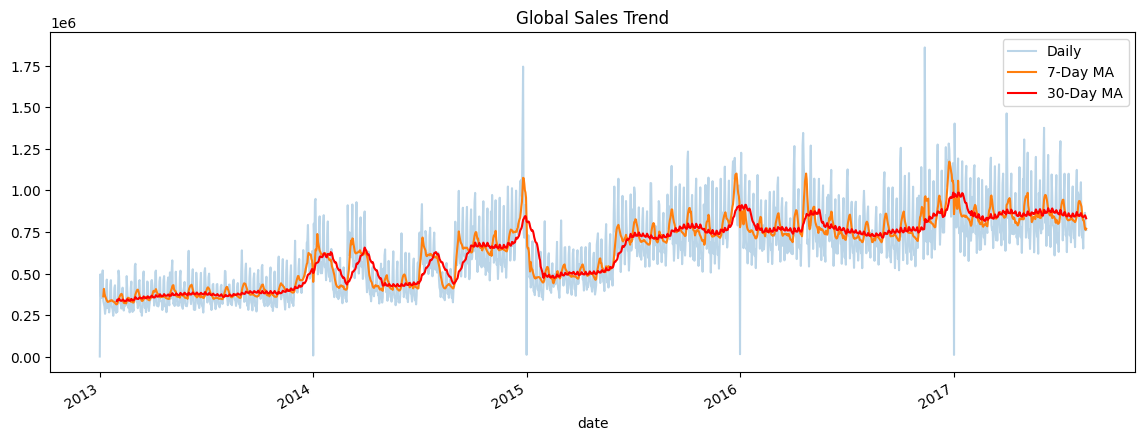

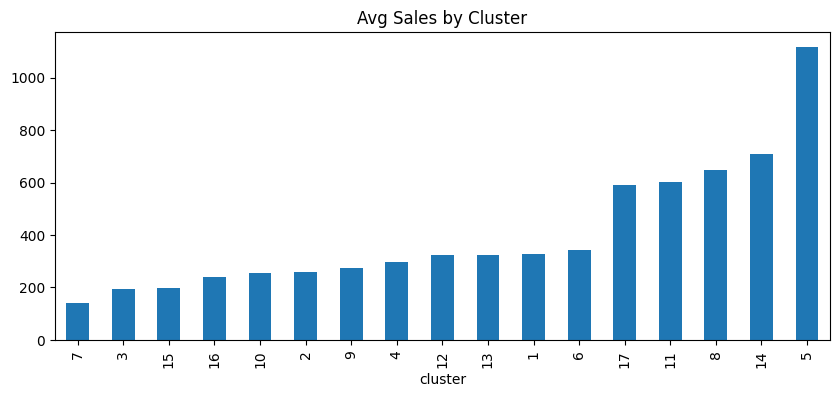

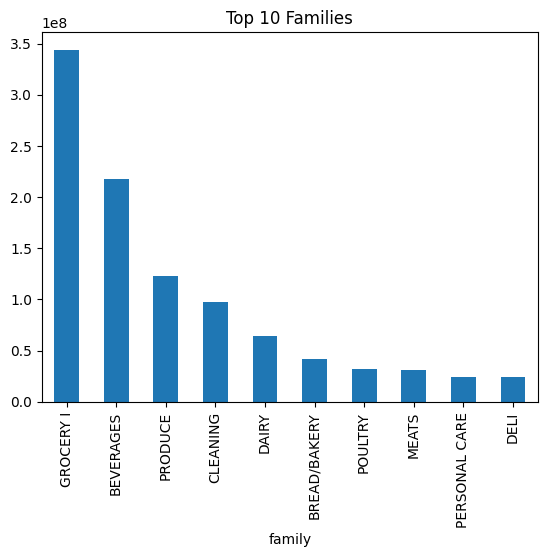


--- Promotion Impact ---
has_promo
0     158.173957
1    1137.819183
Name: sales, dtype: float64

--- Oil Correlation ---
               sales  dcoilwtico
sales       1.000000   -0.627997
dcoilwtico -0.627997    1.000000


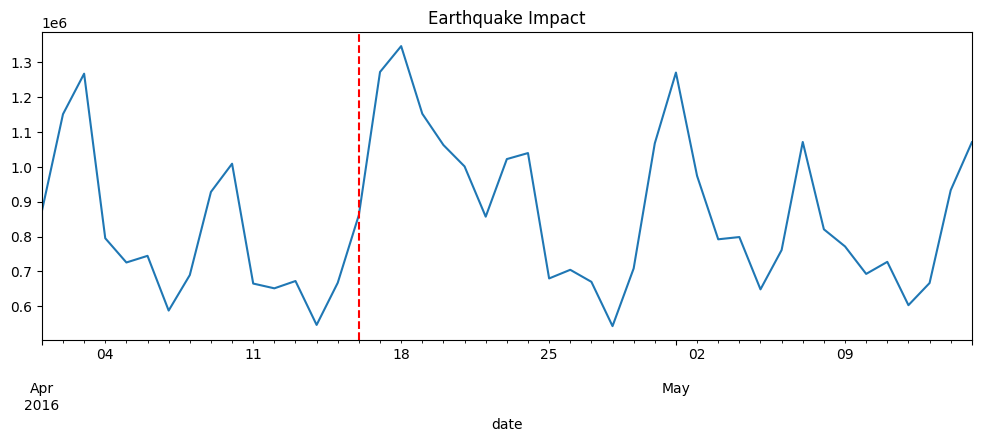


--- Wage Day Effect ---
is_wage_day
0    357.630855
1    362.494890
Name: sales, dtype: float64


In [4]:

print("\nPhase 2: EDA Analysis...")

#Calculates total sales for each day across all stores and product families.
daily_sales = train.groupby("date")["sales"].sum()

#Creates a new plot with width 14 and height 5.
plt.figure(figsize=(14,5))

#Plots daily sales with slight transparency.
daily_sales.plot(alpha=0.3, label="Daily")

#Plots the 7-day moving average of sales.
daily_sales.rolling(7).mean().plot(label="7-Day MA")

#Plots the 30-day moving average of sales in red.
daily_sales.rolling(30).mean().plot(label="30-Day MA", color="red")

#Adds title and legend, then displays the plot.
plt.title("Global Sales Trend"); plt.legend(); plt.show()

#Computes average sales for each store cluster and sorts them.Displays a bar chart of average sales by cluster.
train.groupby("cluster")["sales"].mean().sort_values().plot(kind="bar", figsize=(10,4), title="Avg Sales by Cluster"); plt.show()

#Calculates total sales for each product family and sorts from highest to lowest.
family_sales = train.groupby("family")["sales"].sum().sort_values(ascending=False)

#Plots a bar chart of the top 10 highest-selling product families.
family_sales.head(10).plot(kind="bar", title="Top 10 Families"); plt.show()


#Creates a column indicating whether a product is on promotion (1) or not (0).
train["has_promo"] = (train["onpromotion"] > 0).astype(int)

#hows the average sales with and without promotions.
print("\n--- Promotion Impact ---")
print(train.groupby("has_promo")["sales"].mean())

#Calculates the correlation between daily average sales and oil prices.
print("\n--- Oil Correlation ---")
print(train.groupby("date")[["sales", "dcoilwtico"]].mean().corr())

#Filters data around the earthquake period.
eq = train[(train["date"] >= "2016-04-01") & (train["date"] <= "2016-05-15")]

#Plots total daily sales during the earthquake period.
eq.groupby("date")["sales"].sum().plot(title="Earthquake Impact", figsize=(12,4))

#Draws a red dashed line on the earthquake date and shows the plot.
plt.axvline(pd.to_datetime("2016-04-16"), color="red", linestyle="--"); plt.show()

#Extracts the day number from the date.
train["day"] = train["date"].dt.day

#Creates a column marking the 15th and last day of the month as wage days.
train["is_wage_day"] = ((train["day"] == 15) | (train["date"].dt.is_month_end)).astype(int)

#Displays average sales on wage days versus normal days.
print("\n--- Wage Day Effect ---")
print(train.groupby("is_wage_day")["sales"].mean())


In [5]:

print("\nPhase 3: Feature Engineering...")


#Prepare the test dataset,Merge store information into test data.Merge oil price data,holiday data based on date.
#Replace missing values with 0.Add a sales column as NaN (since test data has no target).

test_merged = test.merge(stores, on="store_nbr", how="left")
test_merged = test_merged.merge(oil, on="date", how="left")
test_merged = test_merged.merge(holidays_clean, on="date", how="left")
test_merged = test_merged.fillna(0) 
test_merged["sales"] = np.nan


#Concatenate train and test datasets.Sort by store, product family, and date to maintain time order.
combined = pd.concat([train, test_merged], sort=False)
combined = combined.sort_values(["store_nbr", "family", "date"])

#creates new time-based features from the date column, such as year, month, day, day of the week, and week of the year capturing seasonal and behavioral sales patterns.
combined["year"] = combined["date"].dt.year
combined["month"] = combined["date"].dt.month
combined["day"] = combined["date"].dt.day
combined["dayofweek"] = combined["date"].dt.dayofweek
combined["weekofyear"] = combined["date"].dt.isocalendar().week.astype(int)
combined["is_weekend"] = (combined["dayofweek"] >= 5).astype(int)
combined["is_month_start"] = combined["date"].dt.is_month_start.astype(int)
combined["is_month_end"] = combined["date"].dt.is_month_end.astype(int)
combined["is_wage_day"] = ((combined["day"] == 15) | (combined["is_month_end"] == 1)).astype(int)

#creates lag features by adding previous sales values (1, 7, 14, and 30 days ago) for each store and product family. 
g = combined.groupby(["store_nbr", "family"])
combined["sales_lag_1"] = g["sales"].shift(1)
combined["sales_lag_7"] = g["sales"].shift(7)
combined["sales_lag_14"] = g["sales"].shift(14)
combined["sales_lag_30"] = g["sales"].shift(30)


#creates rolling statistical features such as 7-day and 30-day average sales, 7-day sales variability, average promotion levels, and average oil prices.
combined["sales_roll_mean_7"] = g["sales"].shift(1).rolling(7).mean().values
combined["sales_roll_mean_30"] = g["sales"].shift(1).rolling(30).mean().values
combined["sales_roll_std_7"] = g["sales"].shift(1).rolling(7).std().values


combined["promo_roll_mean_7"] = g["onpromotion"].shift(1).rolling(7).mean().values


combined["oil_roll_mean_7"] = combined["dcoilwtico"].rolling(7).mean().values


#Convert categorical text columns into numeric codes.
combined["family"] = combined["family"].astype("category").cat.codes
combined["city"] = combined["city"].astype("category").cat.codes
combined["state"] = combined["state"].astype("category").cat.codes
combined["type"] = combined["type"].astype("category").cat.codes


#Separate data back into: train_processed → rows with known sales (for training),test_processed → rows with unknown sales (for prediction)
train_processed = combined[combined["sales"].notna()].copy()
test_processed = combined[combined["sales"].isna()].copy()



Phase 3: Feature Engineering...


In [6]:

print("\nPhase 4: Splitting Data...")

#Extracts all unique dates from training data.Sorts them.Selects the date that is 30 days from the end as the cutoff.
dates = train_processed["date"].sort_values().unique()
cutoff_30 = dates[-30]

#Split the data into:train_modeling → earlier data used for training and validation.final_holdout → last 30 days reserved for final evaluation.
train_modeling = train_processed[train_processed["date"] < cutoff_30].copy()
final_holdout = train_processed[train_processed["date"] >= cutoff_30].copy()

#Extract unique dates from the modeling data.Select the date at the 80% point of the timeline.
model_dates = train_modeling["date"].sort_values().unique()
split_date = model_dates[int(0.8 * len(model_dates))]

#Split the modeling data into:train_set → first 80% of dates.val_set → last 20% of dates.
train_set = train_modeling[train_modeling["date"] <= split_date].copy()
val_set = train_modeling[train_modeling["date"] > split_date].copy()

#elects the input feature columns by excluding non-relevant fields like ID, date, and target variables. 
#It then removes rows with missing feature values and separates the data into training inputs (X) and target outputs (y) for both training and validation sets.
features = [c for c in train_set.columns if c not in ["id", "date", "sales", "has_promo"]]
train_set = train_set.dropna(subset=features)
val_set = val_set.dropna(subset=features)
final_holdout = final_holdout.dropna(subset=features)

X_train, y_train = train_set[features], train_set["sales"]
X_val, y_val = val_set[features], val_set["sales"]


Phase 4: Splitting Data...


In [7]:


print("\nPhase 5: Training all 5 Models...")

#Imports the time module and records the start time
import time
start_time = time.time()

#Ensures the date columns are in proper datetime format
train_set["date"] = pd.to_datetime(train_set["date"])
val_set["date"] = pd.to_datetime(val_set["date"])

#Defines a function to calculate performance metrics for each model.
def get_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    y_safe = np.where(y_true == 0, 0.001, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_safe))
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

#Creates an empty list to store model evaluation results.
results = []

#Calculates total actual daily sales in the validation dataset.
val_daily_actual = val_set.groupby("date")["sales"].sum().sort_index()


#Creates a Linear Regression model using all CPU cores.Trains the model on the training data.Predicts sales on the validation data.
print("Training Linear Regression...")
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)

#Aggregates predicted sales into daily totals.
pred_daily_lr = (
    pd.Series(pred_lr, index=val_set.index)
    .groupby(val_set["date"])
    .sum()
    .sort_index()
)

#Calculates performance metrics and stores the results.
results.append(get_metrics(val_daily_actual.values,
                           pred_daily_lr.values,
                           "Linear Regression"))


#Creates the Random Forest model,Trains the model,Predicts validation sales.
print("Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

#Aggregates predictions to daily totals.
pred_daily_rf = (
    pd.Series(pred_rf, index=val_set.index)
    .groupby(val_set["date"])
    .sum()
    .sort_index()
)

#Stores the evaluation metrics.
results.append(get_metrics(val_daily_actual.values,
                           pred_daily_rf.values,
                           "Random Forest"))


#Creates the XGBoost model,Trains the model,Predicts validation sales.
print("Training XGBoost...")
xgb = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    tree_method="hist",
    verbosity=0
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_val)

#Aggregates predictions into daily totals.
pred_daily_xgb = (
    pd.Series(pred_xgb, index=val_set.index)
    .groupby(val_set["date"])
    .sum()
    .sort_index()
)

#Stores the evaluation results.
results.append(get_metrics(val_daily_actual.values,
                           pred_daily_xgb.values,
                           "XGBoost"))

#Creates daily aggregated sales for training and validation.
print("Training ARIMA...")
daily_train = train_set.groupby("date")["sales"].sum().sort_index()
daily_val = val_set.groupby("date")["sales"].sum().sort_index()

#Ensures continuous daily time series and fills missing days.
daily_train = daily_train.asfreq("D").fillna(0)
daily_val = daily_val.asfreq("D").fillna(0)

#Trains the ARIMA time series model.Forecasts sales for the validation period.
arima = ARIMA(daily_train, order=(2,1,2)).fit()
pred_arima = arima.forecast(steps=len(daily_val))

#Stores ARIMA evaluation metrics.
results.append(get_metrics(daily_val.values,
                           pred_arima.values,
                           "ARIMA"))


#Creates a seasonal ARIMA model.Trains the SARIMA model.Forecasts validation sales.
print("Training SARIMA...")
sarima = SARIMAX(
    daily_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred_sarima = sarima.forecast(steps=len(daily_val))

#Stores SARIMA evaluation metrics.
results.append(get_metrics(daily_val.values,
                           pred_sarima.values,
                           "SARIMA"))


#Converts results into a table.Prints models sorted by RMSE (best performance first).
print("\n--- Model Comparison Table (Daily Level) ---")
results_df = pd.DataFrame(results).set_index("Model")
print(results_df.sort_values("RMSE"))

best_model = xgb

end_time = time.time()
print(f"\nTotal Runtime: {(end_time - start_time)/60:.2f} minutes")



Phase 5: Training all 5 Models...
Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training ARIMA...
Training SARIMA...

--- Model Comparison Table (Daily Level) ---
                             MAE           RMSE          MAPE        R2
Model                                                                  
XGBoost             53903.963872   94945.092423  2.589833e-01  0.766996
Random Forest       59266.137964  102123.839278  3.216265e-01  0.730430
Linear Regression   73709.130737  123479.992471  3.729806e-01  0.605896
ARIMA              178599.307735  247790.000717  2.116622e+06 -0.507368
SARIMA             205698.373897  253356.697271  2.621911e+06 -0.575856

Total Runtime: 7.56 minutes



Phase 6: Final 30-Day Validation...

--- Final 30-Day Results (Granular) ---
                        MAE       RMSE        MAPE        R2
Model                                                       
Final Validation  61.038734  210.66477  222.799126  0.972153


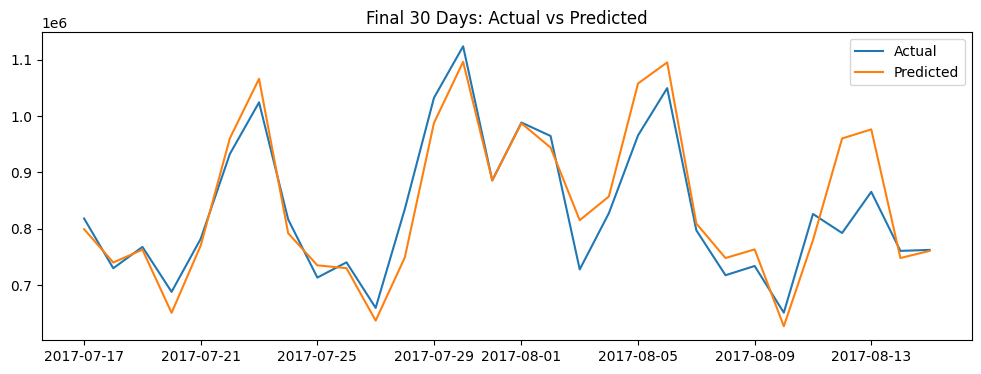

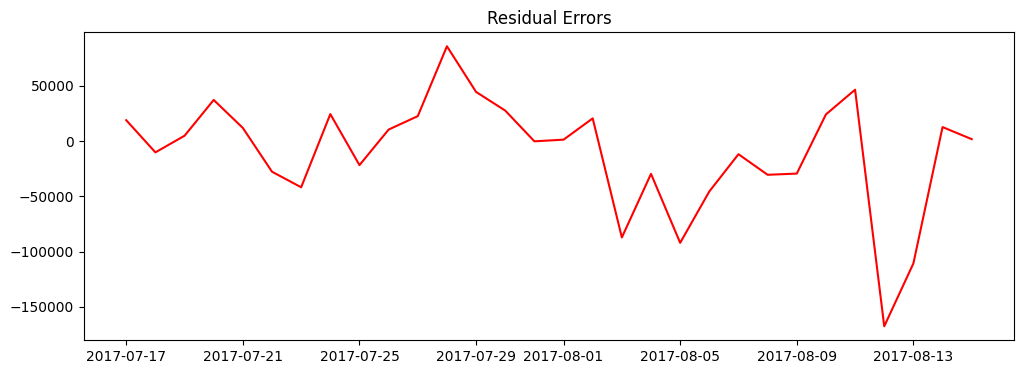

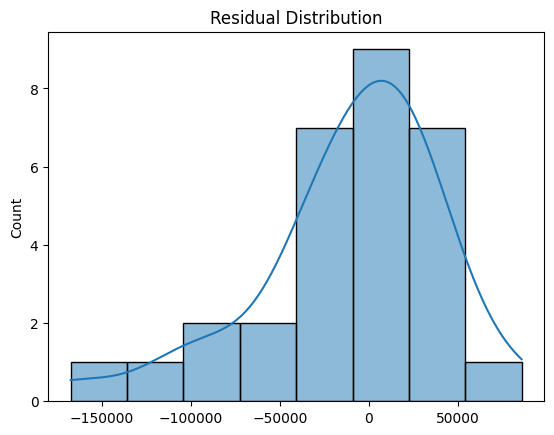

In [8]:
print("\nPhase 6: Final 30-Day Validation...")

#Removes rows with missing feature values from the full training dataset.Retrains the selected best model using the entire cleaned training data.
full_train_clean = train_modeling.dropna(subset=features)
best_model.fit(full_train_clean[features], full_train_clean["sales"])

#Predicts sales for the final 30-day holdout dataset.
pred_final = best_model.predict(final_holdout[features])

#Calculates performance metrics for the final predictions.Shows the final evaluation metrics in table format.
final_metrics = get_metrics(final_holdout["sales"], pred_final, "Final Validation")
print("\n--- Final 30-Day Results (Granular) ---")
print(pd.DataFrame([final_metrics]).set_index("Model"))

#Calculates total actual sales per day for the final 30-day period.Calculates total predicted sales per day for the same period.
daily_final_actual = final_holdout.groupby("date")["sales"].sum()
daily_final_pred = pd.Series(pred_final, index=final_holdout.index).groupby(final_holdout["date"]).sum()

#Creates a plotting area for the comparison chart.
plt.figure(figsize=(12,4))
plt.plot(daily_final_actual.index, daily_final_actual, label="Actual")
plt.plot(daily_final_actual.index, daily_final_pred, label="Predicted")
plt.title("Final 30 Days: Actual vs Predicted"); plt.legend(); plt.show()

#Calculates the difference between actual and predicted sales (prediction errors).Plots the residual errors over time,Displays a histogram of residuals to check the distribution of prediction errors.
residuals = daily_final_actual - daily_final_pred
plt.figure(figsize=(12,4))
plt.plot(residuals, color="red"); plt.title("Residual Errors"); plt.show()
sns.histplot(residuals, kde=True); plt.title("Residual Distribution"); plt.show()


Phase 7: Generating Future Forecast & Submission

[Step 1] Retraining model on full training data...
Training rows after dropna: 2950992
✓ Model retrained successfully

[Step 2] Generating predictions for all 15 days...
test_processed rows: 28512
Unique dates in test: 16
Test rows after fillna: 28512
Predictions generated: 28512

[Step 3] Creating submission file...
✓ Saved: submission.csv

[Step 4] Aggregating forecast by date...

Number of forecast days: 16
Date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00

[Step 5] Generating forecast visualization...
Forecast points (including connection): 17


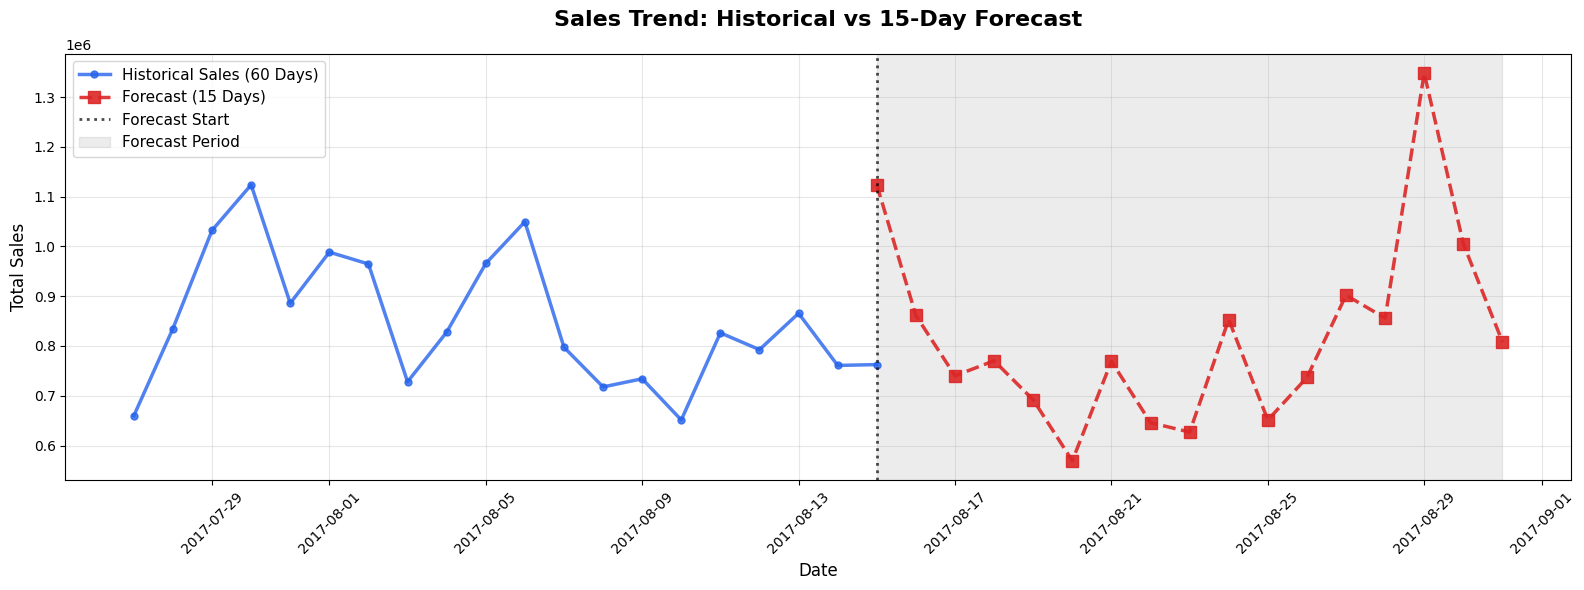

In [9]:

print("Phase 7: Generating Future Forecast & Submission")


# Retrain Best Model on Full Training Data
print("\n[Step 1] Retraining model on full training data...")

full_data = train_processed.dropna(subset=features)
print(f"Training rows after dropna: {len(full_data)}")

best_model.fit(full_data[features], full_data["sales"])
print("✓ Model retrained successfully")


#  Predict on FULL Test Set (All 15 Days)

print("\n[Step 2] Generating predictions for all 15 days...")

print(f"test_processed rows: {len(test_processed)}")
print(f"Unique dates in test: {test_processed['date'].nunique()}")

test_full = test_processed.copy()
test_full[features] = test_full[features].fillna(0)
print(f"Test rows after fillna: {len(test_full)}")

future_preds_full = best_model.predict(test_full[features])
print(f"Predictions generated: {len(future_preds_full)}")


# STEP 3: Create Submission File

print("\n[Step 3] Creating submission file...")

test_original = pd.read_csv("test.csv", parse_dates=["date"])
test_original['predicted_sales'] = future_preds_full

submission = pd.DataFrame({
    "id": test_original['id'].astype(int),
    "sales": np.clip(future_preds_full, 0, None)
})

submission.to_csv("submission.csv", index=False)
print("✓ Saved: submission.csv")


# STEP 4: Aggregate Forecast by Date (for Plotting)

print("\n[Step 4] Aggregating forecast by date...")

forecast_daily = test_original.groupby('date')['predicted_sales'].sum().reset_index()
forecast_daily = forecast_daily.sort_values('date')

print(f"\nNumber of forecast days: {len(forecast_daily)}")
print(f"Date range: {forecast_daily['date'].min()} to {forecast_daily['date'].max()}")


# STEP 5: Plot Historical vs Forecast

print("\n[Step 5] Generating forecast visualization...")

# Get historical data (last 20 days)
historical_daily = train_processed.groupby('date')['sales'].sum().reset_index()
historical_daily = historical_daily.tail(20).copy()


last_historical_point = pd.DataFrame({
    'date': [historical_daily['date'].max()],
    'predicted_sales': [historical_daily['sales'].max()]
})

# Combine last historical point with forecast (for continuous line)
forecast_connected = pd.concat([last_historical_point, forecast_daily], ignore_index=True)
forecast_connected = forecast_connected.sort_values('date')

print(f"Forecast points (including connection): {len(forecast_connected)}")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot Historical Sales (Blue Solid Line)
ax.plot(historical_daily['date'], 
        historical_daily['sales'], 
        color='#2563eb', 
        linewidth=2.5, 
        label='Historical Sales (60 Days)', 
        marker='o', 
        markersize=5,
        alpha=0.8)

# Plot Forecast Sales (Red Dashed Line)
ax.plot(forecast_connected['date'], 
        forecast_connected['predicted_sales'], 
        color='#dc2626', 
        linewidth=2.5, 
        label='Forecast (15 Days)', 
        marker='s', 
        markersize=8, 
        linestyle='--',
        alpha=0.9)

# Add vertical line at forecast start
forecast_start = historical_daily['date'].max()
ax.axvline(x=forecast_start, 
           color='black', 
           linestyle=':', 
           linewidth=2, 
           label='Forecast Start',
           alpha=0.7)

# Add shaded region for forecast period
ax.axvspan(forecast_start, 
           forecast_daily['date'].max(), 
           alpha=0.15, 
           color='gray', 
           label='Forecast Period')

# Formatting
ax.set_title("Sales Trend: Historical vs 15-Day Forecast", 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Total Sales", fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

